In [3]:
print("hello")

hello


In [4]:
from dotenv import load_dotenv
import os


In [5]:
load_dotenv()

True

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",      # Changed from 2.5 (which likely doesn't exist) to 1.5
    google_api_key=os.getenv("GEMINI_API_KEY") # Changed parameter name
)

In [7]:
llm

ChatGoogleGenerativeAI(profile={'max_input_tokens': 1048576, 'max_output_tokens': 65536, 'image_inputs': True, 'audio_inputs': True, 'pdf_inputs': True, 'video_inputs': True, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': True, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'image_tool_message': True, 'tool_choice': True}, google_api_key=SecretStr('**********'), model='gemini-2.5-flash', client=<google.genai.client.Client object at 0x121b24dd0>, default_metadata=(), model_kwargs={})

In [8]:
llm.invoke("Hey, I missed you sooo much")

AIMessage(content="Aww, that's so sweet to hear! I've missed our chats too. 🤗\n\nHow have you been? What's on your mind?", additional_kwargs={}, response_metadata={'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': [], 'model_provider': 'google_genai'}, id='lc_run--019c046d-e232-7831-a9c0-d4116a8b0b1b-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 8, 'output_tokens': 635, 'total_tokens': 643, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 602}})

In [9]:
from langchain_groq import ChatGroq

# Retrieve the API key from the environment variable
os.getenv("GROQ_API_KEY")

# Pass the API key to the ChatGroq class
llm_groq = ChatGroq(model="llama-3.1-8b-instant", temperature=0, max_tokens=128)

llm_groq.invoke("Hello!")

AIMessage(content="Hello! It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 37, 'total_tokens': 63, 'completion_time': 0.023712884, 'completion_tokens_details': None, 'prompt_time': 0.002398545, 'prompt_tokens_details': None, 'queue_time': 0.077332298, 'total_time': 0.026111429}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_6c980774ec', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c046d-f2d8-7a90-b7d2-a1d80d3f7bb4-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 37, 'output_tokens': 26, 'total_tokens': 63})

## Building first ReAct agent using Langchain

In [10]:
from langchain.agents import create_agent

agent = create_agent(llm_groq, tools=[])

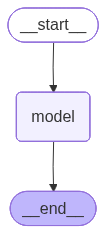

In [11]:
agent

In [12]:
agent.invoke({"messages":[("user","Hi there !")]})

{'messages': [HumanMessage(content='Hi there !', additional_kwargs={}, response_metadata={}, id='01940a18-bc56-4875-b015-438b46f73cf5'),
  AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 38, 'total_tokens': 61, 'completion_time': 0.024159261, 'completion_tokens_details': None, 'prompt_time': 0.005302646, 'prompt_tokens_details': None, 'queue_time': 0.035803157, 'total_time': 0.029461907}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_020e283281', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c046d-f56d-7c33-8eb0-289888650f44-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 38, 'output_tokens': 23, 'total_tokens': 61})]}

# Adding dummy tool

In [13]:
from langchain.tools import tool

In [14]:
@tool
def dummy_tool(inputText: str) -> str:
    """Convert input text to uppercase. This is just for testing.
    
    Args: 
        inputText {str} -- input text to be converted to uppercase
    """

    return f"Output : {inputText.upper()}"

In [15]:
tools = [dummy_tool]

agent_dummy_tool = create_agent(llm_groq, tools=tools)

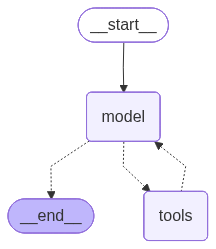

In [16]:
agent_dummy_tool

In [17]:
res = agent_dummy_tool.invoke({"messages":[("user","use the dummy tool on 'react agents' ")]})

In [18]:
res

{'messages': [HumanMessage(content="use the dummy tool on 'react agents' ", additional_kwargs={}, response_metadata={}, id='757076e3-fcc2-4073-b0a8-9cabb3728690'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gfpgrdbmn', 'function': {'arguments': '{"inputText":"react agents"}', 'name': 'dummy_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 275, 'total_tokens': 292, 'completion_time': 0.02497865, 'completion_tokens_details': None, 'prompt_time': 0.02336125, 'prompt_tokens_details': None, 'queue_time': 0.038779786, 'total_time': 0.0483399}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_020e283281', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c046d-f6fd-75b1-a92f-7289d74e508f-0', tool_calls=[{'name': 'dummy_tool', 'args': {'inputText': 'react agents'}, 'id': 'gfpgrdbmn', 'type': 'tool_call'}], invalid_tool_calls=[], 

# Adding weather tool

In [19]:
import requests

In [20]:
@tool
def get_weather(city:str)-> dict:
    """ Get the current weather for a given city"""
    try:
        geo_url = f"https://geocoding-api.open-meteo.com/v1/search?name={city}&count=1&language=en&format=json"
        geo_data = requests.get(geo_url).json()
        if not geo_data.get("results"):
            return {"error": f"City {city} not found"}
        location = geo_data["results"][0]
        lat, lon = location["latitude"], location["longitude"]
        print(lat,lon)
        weather_url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&current=temperature_2m,weather_code"
        data = requests.get(weather_url).json()
        temp = data["current"]["temperature_2m"]
        return {"city": city, "temp":temp,"unit":"C"}
    except Exception as e:
        return {"error":str(e)}

In [21]:
print(get_weather.invoke("Kolkata"))

22.56263 88.36304
{'city': 'Kolkata', 'temp': 23.9, 'unit': 'C'}


In [22]:
tools.append(get_weather)

agent_weather = create_agent(llm, tools = tools)

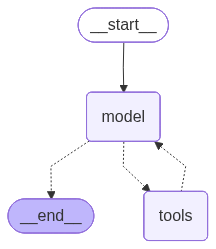

In [23]:
agent_weather

In [24]:
agent_weather.invoke({"messages":[("user","Can you give me the current temperature of Middletown")]})

40.39428 -74.11709


{'messages': [HumanMessage(content='Can you give me the current temperature of Middletown', additional_kwargs={}, response_metadata={}, id='79d9860f-176c-4c70-81de-713b96f48ca3'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Middletown"}'}, '__gemini_function_call_thought_signatures__': {'93e3b4db-4d07-422b-843e-78484900bb3d': 'CocEAXLI2nzba62hvTlQFQAVDHuCC1U0Pvt+094RDdCPH2UCl1BUuxcU+3tNzvs54/eCMOvhQ9K7H9YIegTRshKSElP1gsT65exDONewvy3igIfJJF0+e6741Gg5mY572vFc6ksxWhCXuKDyrQGhRZu27PcRsrwMHcNJ0K1dAabQZiGVesZsBD1o3TBemdzZqOYW4ZkGKQ/+BB+mcDiJa2ls45Sh7WrxD1YFQj8SL+Iq5x/b8aDzVxb84Fz55U0JCFdD0NtRP7nHlo2HvEvhMqHxYar5ZUhM3GgkZ7bEQ02bvcadVFiwh3IxWwlhY8pGESgNyUt0qdGWMkfliPrDrcIS1DjB0dF4IOrn6ctLKH9ls8Q3zM7eSF4lMQaCq8iwQn5AtmLj5UaaArDqQ90QzUGNr2kRZaZVtetDxLLKETnNwN6sQzatP1DWFETwOEs3SV3QLs2/RLT9FHX3NyVA3xA3lebAk4HZQ40Xkr9O5HE5aRwaxxnb/EJp/lMI9b6cnMOswqoLPvbBbXJJwRLcwQo4zm9t67B3CbWKzgqQavnY/ifZ9qlp7VwhhsL2qARc24132Q9JqWhw8rUafrY4lyP/MCeSPc2

In [25]:
agent_weather.invoke({"messages":[("user","Can you convert 'hello there' in uppercase and also give me the current temperature of Delhi and Kolkata.")]})

22.56263 88.36304
28.65195 77.23149


{'messages': [HumanMessage(content="Can you convert 'hello there' in uppercase and also give me the current temperature of Delhi and Kolkata.", additional_kwargs={}, response_metadata={}, id='22f09803-3f3c-4b12-88f7-8e25a0db4b6a'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_weather', 'arguments': '{"city": "Kolkata"}'}, '__gemini_function_call_thought_signatures__': {'21abb46c-e53b-473f-8e69-3b449dc51b34': 'CsQGAXLI2nyOPlF9mx7jKseUYbQnvI7tOVhX/fKy2HPBN3GdO60WRqrC8anu4gZ3G8ujdpF2PJdBHnRP4tRXdz/AblWvtMEsdf6RT8d+GAqsdV7Mz4GEve/HVzycxUiJ+Nww+Oy0nXJ8kl+fYFHHeDamifTlXJ1xoVThO//9feKcGBKrsyvfg8DsWa0HryI61dD4M/WIWuTPR+L+qobEOA//JA9LcH2yHaFJA9Gka8EzTnFDAnuZnXPwmgE3FIsBuoOnfTnzN8uYjVssdKr4fnoDdby67Z0aar3ygNvBfeYieDKG2X+dcdDvQx8xbwSG8YCffyLnSPOdoqc5/aRUa09lmySRKVr/1MJfMDsjShX3ympMruVDONCpKMsnirVMyDOZF2dWcA42hpk0QfAY53tvScd4/l+dz0EWihwkVvasLl0QcZLHs7DLqr8imjUKisEE4tYoxD5tdgZcLXpe1eTQqx/G+fjTSsXmUFUeMafW+F5LYqpzraKpE9KAnKPqswHTkQWOI6NM5gajVSb6CfTDpG8KfkeKj6lpzenpWUxtN8

## Notes Tool Implementation

In [ ]:
@tool
def get_notes() -> list:
    """Get all pending notes from Notion"""
    api_key = os.getenv("NOTION_API_KEY")
    db_id = os.getenv("NOTION_NOTES_DB_ID")

    if not api_key or not db_id:
        return ["Error: Notion API Key or DB id not set"]
    
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type" : "application/json",
        "Notion-Version":"2022-06-28"
    }

    url = f"https://api.notion.com/v1/databases/{db_id}/query"

    payload = {
        "filter":{
            "property":"Status",
            "select":{
                "equals":"Pending"
            }
        }
    }

    try:
        res = requests.post(url, headers=headers, json=payload)
        res.raise_for_status()
        data = res.json()

        notes = []
        for page in data.get("results",[]):
            props = page.get("properties", {})
            title_list = props.get("Note", {}).get("title", {})
            note_content = title_list[0].get("text",{}).get("content", "") if title_list else "Untitled Note"
            notes.append(note_content)

        return notes
    
    except Exception as e:
        return [f"Error Fetching Notes: {str(e)}"]

@tool
def add_notes(note:str)->str:
    """Add a new note to Notion"""
    api_key = os.getenv("NOTION_API_KEY")
    db_id = os.getenv("NOTION_NOTES_DB_ID")

    if not api_key or not db_id:
        return "Error: Notion API Key or DB id not set"

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type" : "application/json",
        "Notion-Version":"2022-06-28"
    }

    url="https://api.notion.com/v1/pages"


    payload = {
        "parent" : {"database_id":db_id},
        "properties":{
            "Note":{
                "title" : [{"text":{"content":note}}]
            },
            "Status": {
                "select":{"name": "Pending"}
            }
        }
    }

    try:
        res = requests.post(url, headers=headers, json=payload)
        res.raise_for_status()
        return f"Note added successfully: {note}"
    except Exception as e:
        return f"Error adding note: {str(e)}"

['LeetCode']